In [3]:
from dataclasses import dataclass
import tyro

from pathlib import Path

import gymnasium as gym
import torch
from agent import Agent
from mani_skill.utils.wrappers.flatten import FlattenActionSpaceWrapper
from mani_skill.utils.wrappers.record import RecordEpisode
from mani_skill.vector.wrappers.gymnasium import ManiSkillVectorEnv
from mani_skill.utils import gym_utils

from twsim.envs import plane  # noqa: F401
from twsim.robots import transwheel  # noqa: F401

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

sns.set_context("paper")
sns.set_style("ticks")

In [4]:
@dataclass
class Args:
    "Evaluate a trained policy."

    # fmt: off

    checkpoint: str                          # Path to the checkpoint file
    env_id: str                              # Environment ID
    control_mode: str = "wheel_vel_ext_pos"  # Control mode
    capture_video: bool = True               # Save videos to ./runs/{run_name}/test_videos
    num_eval_envs: int = 1                   # Number of parallel evaluation environments
    num_eval_steps: int = 500                # Number of steps to run in each evaluation environment
    eval_reconfiguration_freq: int = 1       # Reconfigure the environment each reset to ensure objects are randomized
    eval_partial_reset: bool = False         # Let parallel evaluation environments reset upon termination instead of truncation
    cuda: bool = True                        # Use GPU for evaluation

    # fmt: on

# checkpoint = 'runs/Stiffer/final_ckpt.pt'
# checkpoint = 'runs/PlaneVel-v1__train-ppo__1__1747949506/final_ckpt.pt'
# checkpoint = 'runs/Step/final_ckpt.pt'
# checkpoint = 'runs/StepEnv/final_ckpt.pt'
checkpoint = 'runs/SensorEnvLongLong/ckpt_576.pt'

# env_id = 'StepVel-v1'
env_id = 'StepVelSensor-v1'

args = Args(checkpoint, env_id)

device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

env_kwargs = dict(
    obs_mode="state",
    render_mode="rgb_array",
    sim_backend="physx_cuda",
    control_mode=args.control_mode,
    # human_render_camera_configs=dict(shader_pack="rt"),
)

eval_output_dir = Path(args.checkpoint).parent / env_id

overwrite = True
print('Checking', eval_output_dir)
if (not overwrite) and eval_output_dir.exists():
    raise SystemError("Make sure that you are not overwriting existing output.")


eval_output_dir = str(eval_output_dir)
print(f"Saving eval videos to {eval_output_dir}")

Checking runs/SensorEnvLongLong/StepVelSensor-v1
Saving eval videos to runs/SensorEnvLongLong/StepVelSensor-v1


In [5]:
# Create the evaluation environment
eval_envs = gym.make(
    args.env_id,
    num_envs=args.num_eval_envs,
    reconfiguration_freq=args.eval_reconfiguration_freq,
    **env_kwargs,  # type: ignore
)

# Flatten action spaces if needed
if isinstance(eval_envs.action_space, gym.spaces.Dict):
    eval_envs = FlattenActionSpaceWrapper(eval_envs)

eval_envs = RecordEpisode(
    eval_envs,  # type: ignore
    output_dir=eval_output_dir,
    save_trajectory=False,
    max_steps_per_video=args.num_eval_steps,
    video_fps=30,
)

eval_envs = ManiSkillVectorEnv(
    eval_envs,  # type: ignore
    args.num_eval_envs,
    ignore_terminations=not args.eval_partial_reset,
    record_metrics=True,
)

In [6]:
eval_envs.unwrapped.print_sim_details()  # type: ignore
print(f"{eval_envs.unwrapped.reward_mode=}")  # type: ignore

# -------------------------------------------------------------------------- #
Task ID: StepVelSensor-v1, 1 parallel environments, sim_backend=physx_cuda
obs_mode=state, control_mode=wheel_vel_ext_pos
render_mode=rgb_array, sensor_details=
sim_freq=100, control_freq=20
observation space: Box(-inf, inf, (1, 19), float32)
(single) action space: Box(-1.0, 1.0, (8,), float32)
# -------------------------------------------------------------------------- #
eval_envs.unwrapped.reward_mode='normalized_dense'


In [ ]:
print("Evaluating")

labels = ["elapsed_steps", "velx", "vely", "velz", "vel", "velocity_error", "reward_velocity", "extension", "reward_extension", "reward", "contact", "distance"]
df_rows = []

eval_obs, _ = eval_envs.reset()
num_episodes = 0

observation_shape = eval_envs.single_observation_space.shape
action_shape = eval_envs.single_action_space.shape

agent = Agent(observation_shape, action_shape).to(device)
agent.load_state_dict(torch.load(args.checkpoint))
agent.eval()

num_steps = min(gym_utils.find_max_episode_steps_value(eval_envs._env), args.num_eval_steps)

for step in tqdm(range(num_steps)):
    with torch.no_grad():
        eval_action = agent.get_action(eval_obs, deterministic=True)
        eval_obs, eval_reward, _, _, eval_infos = eval_envs.step(eval_action)
            
        if "final_info" in eval_infos:
            mask = eval_infos["_final_info"]
            num_episodes += mask.sum()
            break

        eval_infos["velx"] = eval_infos["velocity"].squeeze()[0]
        eval_infos["vely"] = eval_infos["velocity"].squeeze()[1]
        eval_infos["velz"] = eval_infos["velocity"].squeeze()[2]
        eval_infos["vel"] =  eval_infos["velocity"].squeeze().norm()

        if "distance" in eval_infos:
            eval_infos["contact"] = eval_infos["distance"] < 0.01
            
        eval_infos["reward"] = eval_reward
    
        df_rows.append({l: eval_infos[l].item() for l in labels if l in eval_infos})

total_eval_steps = args.num_eval_steps * args.num_eval_envs
print(f"Evaluated {step} steps resulting in {num_episodes} episodes")

eval_envs.close()

Evaluating


/tmp/ipykernel_2841212/1146924217.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.load_state_dict(torch.load(args.checkpoint))


  0%|          | 0/200 [00:00<?, ?it/s]

[libx264 @ 0x7b559c0] frame MB size (640x360) > level limit (139264)
[libx264 @ 0x7b559c0] DPB size (4 frames, 921600 mbs) > level limit (3 frames, 696320 mbs)


In [6]:
df = pd.DataFrame(df_rows)
df.head()

,elapsed_steps,velx,vely,velz,vel,velocity_error,reward_velocity,extension,reward_extension,reward,contact,distance
0,1,0.197049,-0.010286,0.181800,0.268300,0.209179,0.219795,1.461017,0.102150,0.160972,False,0.054392
1,2,0.189009,0.000555,0.005521,0.189091,0.111130,0.495259,2.307752,0.019600,0.257430,False,0.044419
2,3,0.222593,-0.026892,0.033604,0.226716,0.088568,0.584005,2.301078,0.019861,0.301933,False,0.033939
3,4,0.267035,-0.000330,-0.050367,0.271744,0.060196,0.707789,1.718057,0.062371,0.385080,False,0.021443
4,5,0.294080,-0.003970,0.034646,0.296141,0.035371,0.824964,1.546840,0.086737,0.455851,True,0.007279


In [7]:
df.describe()

,elapsed_steps,velx,vely,velz,vel,velocity_error,reward_velocity,extension,reward_extension,reward,distance
count,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000
mean,100.000000,0.293894,0.031329,0.015600,0.304727,0.083089,0.626070,1.325801,0.252285,0.439177,1.193032
std,57.590508,0.057137,0.029626,0.061931,0.051877,0.048038,0.166735,1.017045,0.183043,0.136579,0.847502
min,1.000000,0.026288,-0.042983,-0.145307,0.052200,0.013450,0.050964,0.246167,0.000024,0.025587,0.000000
25%,50.500000,0.266057,0.011597,-0.023560,0.275667,0.051694,0.535883,0.719569,0.090733,0.362047,0.415903
50%,100.000000,0.300591,0.031404,0.013802,0.309735,0.076106,0.636831,0.999021,0.238817,0.448484,1.147325
75%,149.500000,0.329503,0.048741,0.048779,0.336536,0.100509,0.747139,1.523319,0.383386,0.536996,1.935567
max,199.000000,0.427114,0.102532,0.256542,0.434148,0.364397,0.932853,5.673154,0.758688,0.740698,2.675358


vel [0, 0.4]
velx [0, 0.4]
vely [0, 0.4]
velz [0, 0.4]
velocity_error [0, 0.4]
reward_velocity [0, 1]
extension [-10, 10]
reward_extension [0, 1]
reward [0, 1]
contact [0, 1]
distance [0, 1]


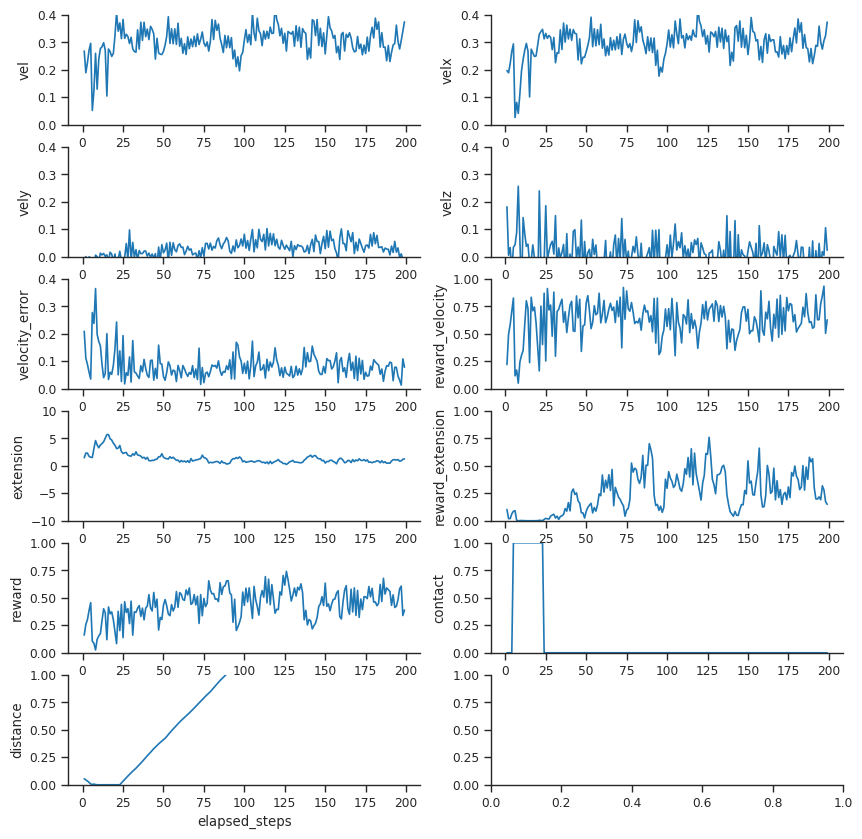

In [8]:
to_plot = [["vel", "velx"], ["vely", "velz"], ["velocity_error", "reward_velocity"], ["extension", "reward_extension"], ["reward", "contact"], ["distance"]]
limits = [[0, 0.4]] * 5 + [[0, 1]] + [[-10, 10]] + [[0, 1]] * 4

num_rows = len(to_plot)
num_cols = len(to_plot[0])

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

labels = [l for row in to_plot for l in row]

for ax, label, lims in zip(axes.flatten(), labels, limits):
    if label not in df.columns: print('Skipping', label); continue
    sns.lineplot(ax=ax, data=df, x="elapsed_steps", y=label)
    ax.set_ylim(lims)
    print(label, lims)

sns.despine()